# Creates a 1-year hourly electricity demand profile assuming full electrification of building heating in Metro Vancouver in the year 2016    

Building heating includes space heating and water heating in the residential and commercial building sectors.

For details on methods, assumptions, and data sources for space heating, refer to Chapter 5.6 in dissertation "How do we power decarbonization? Land and other resources in Canada’s West" http://hdl.handle.net/1828/11659

Note: daylight savings time and February 29 have been removed from all data sources.

12 August 2021 Kevin Palmer-Wilson kevinpw@uvic.ca

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import datetime
from collections import OrderedDict #OrderedDict() allows us to create a legend wthout duplicate items
from os import getcwd, path

In [3]:
# Configuration:
input_path = path.join(getcwd(),'Input data')
output_path = path.join(getcwd(),'Output data')

#version
#version = 'V23-TRANSPORT'
#version = 'V42-LowHeatDemand'

#Define folder structure for input files
#input_path = path.join(getcwd(),'..','data','demand')

#Define folder structure for output files
#fig_prefix = path.join(getcwd(),'figures','demand')
#tab_prefix = path.join(getcwd(),'tables')
#para_prefix = path.join(getcwd(),'OSeMOSYS_params')
#demand_prefix = path.join(getcwd(),'total_hourly_demands')

#Use perturbed space heat demand? (data produced by TempDemandPerturbation.ipynb <- must be run separately)
#perturbSpaceHeat = False #True: use 1996 climate data for space heat demand, False: use 2016 climate data for space heat demand

In [4]:
#the file "Metro Vancouver space and water annual demands and efficiencies.xlsx" contains annual energy demands and a compilation of observed efficiencies. 
#Assumed transformation efficciencies are also included. Let's read that file.
#data = pd.read_excel('../data/demand/Electricity demand scenario data.xlsx', sheet_name='Energy demands and efficiencies', skiprows=2)
data = pd.read_excel(path.join(input_path,'Metro Vancouver space and water annual demands and efficiencies.xlsx'), sheet_name='Energy demands and efficiencies', skiprows=2)

#let's create a function to easily retrieve individual data points from this dataframe
def get(par, col='Applied Value', data=data):
    return data.at[data.index[data['Parameter']==par].tolist()[0],col]

## Annual space heat demand



In [5]:
#Calculate the heat energy demand by multiplying energy consumption with technology efficiencies
E_S_Heat_R_e = get('^E_SR,e')*get('n_SR,e,obs') #Residential electric space heat demand
E_S_Heat_R_f = get('^E_SR,f')*get('n_SR,f,obs') #Residential fossil fuel space heat demand

E_S_Heat_C_e = get('^E_SC,e')*get('n_SC,e,obs') #Commercial historially electric space heat demand
E_S_Heat_C_f = get('^E_SC,f')*get('n_SC,f,obs') #Commercial fossil fuel space heat demand

E_S_Heat_R = E_S_Heat_R_e + E_S_Heat_R_f #Total Residential space heat demand
E_S_Heat_C = E_S_Heat_C_e + E_S_Heat_C_f #Total Commercial space heat demand

E_S_Heat = E_S_Heat_R + E_S_Heat_C #Total residential and commercial space heat demand in Metro Vancouver

print('Vancouver\'s annual space heat demands are')
print('Residential: ',round(E_S_Heat_R,2),' TWh')
print('Commercial: ',round(E_S_Heat_C,2),' TWh')
print('Total: ',round(E_S_Heat,3),' TWh')

Vancouver's annual space heat demands are
Residential:  8.92  TWh
Commercial:  6.21  TWh
Total:  15.135  TWh


## Annual water heat demand

In [6]:
#Calculate the heat energy demand by multiplying energy consumption with technology efficiencies
E_W_Heat_R_e = get('^E_WR,e')*get('n_WR,e,obs') #Residential electric water heat demand
E_W_Heat_R_f = get('^E_WR,f')*get('n_WR,f,obs') #Residential fossil fuel water heat demand

E_W_Heat_C_e = get('^E_WC,e')*get('n_WC,e,obs') #Commercial historially electric water heat demand
E_W_Heat_C_f = get('^E_WC,f')*get('n_WC,f,obs') #Commercial fossil fuel water heat demand

E_W_Heat_R = E_W_Heat_R_e + E_W_Heat_R_f #Total Residential water heat demand
E_W_Heat_C = E_W_Heat_C_e + E_W_Heat_C_f #Total Commercial water heat demand

E_W_Heat = E_W_Heat_R + E_W_Heat_C #Total residential and commercial water heat demand in Metro Vancouver

print('Vancouver\'s annual water heat demands are')
print('Residential: ',round(E_W_Heat_R,2),' TWh')
print('Commercial: ',round(E_W_Heat_C,2),' TWh')
print('Total: ',round(E_W_Heat,3),' TWh')

Vancouver's annual water heat demands are
Residential:  4.54  TWh
Commercial:  0.65  TWh
Total:  5.181  TWh


## Total Annual Space and Water Heat Demand

In [7]:
E_H = E_S_Heat + E_W_Heat

print('Vancouver\'s total annual space and water heat demand in the residential and commercial sectors is: ',round(E_H,3),' TWh')

Vancouver's total annual space and water heat demand in the residential and commercial sectors is:  20.316  TWh


## Space Heat Demand Profile

### Residential space heat demand profile

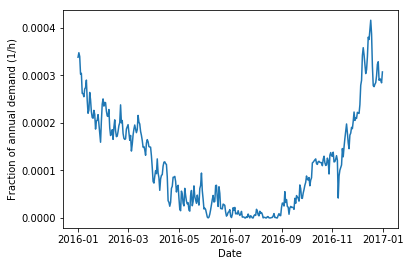

In [8]:
#Residential space heating demand is derived from proprietary residenrial load data from 2995 dwellings in the Lower Mainland
#of British Columbia, spanning November 2015 to October 2017. 890 of those dewllings are taggged to use electric heating.
P_SR = pd.read_excel(path.join(input_path,'Residential_electric_demand_profile_by_housetype.xlsx'), sheet_name='2016_wout_Feb29_wout_DaylightST')

#lets create a datetime column
P_SR['Datetime'] = pd.to_datetime(P_SR['Date'].astype(str) + ' ' + (P_SR['Hour_Ending'] -1).astype(str) + ':00')

#Weights are the number of electrically heated dwellings for this type dwelling in the dataset.
#We assume that the dataset is a representative sample of British Columbia and Vancouver.
wLR = 265 #low-rise Apartments
wSD = 233 #Single/Duplex Homes
wHR = 198 #High-rise Apartments
wRH = 174 #Row Houses
wMH = 20  #Mobile Homes

#Weight each housetypes demand by the number of houses to create the total residential demand
P_SR['Total'] = (P_SR['Residential - Low-Rise Apt Suites (Elec Heat)'] * wLR +
                P_SR['Residential - High-Rise Apt Suites (Elec Heat)'] * wHR +
                P_SR['Residential - Row Houses Units (Elec Heat)'] * wRH +
                P_SR['Residential - Single/Duplex (Elec Heat)'] * wSD +
                P_SR['Residential - Mobile (Elec Heat)'] * wMH
               )

#Normalize the resdidential demand profile
P_SR['Normalized_Total'] = P_SR['Total'] / P_SR['Total'].sum()
                
#plot the residential space heat demand profile as fraction of annual demand
ax = sns.lineplot(x = P_SR['Date'], y = P_SR['Normalized_Total'], legend = 'full', ci = None)
ylabel = plt.ylabel('Fraction of annual demand (1/h)')

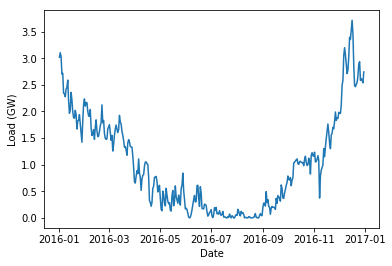

In [9]:
#plot the residential space heat demand profile as load
ax = sns.lineplot(x = P_SR['Date'], y = P_SR['Normalized_Total'] * (E_S_Heat_R)  * 1000, legend = 'full', ci = None)
ylabel = plt.ylabel('Load (GW)')

### Commercial & Institutional space heat demand profile

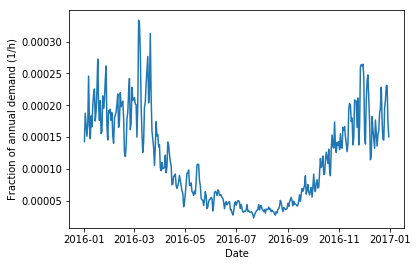

In [10]:
#Commmercial space heat demand profile is derived from 16 types of reference building models published by US DOE.
#Buildings are weighted to match the building stock in British Columbia
#source data available at: https://openei.org/doe-opendata/dataset/commercial-and-residential-hourly-load-profiles-for-all-tmy3-locations-in-the-united-states

#File names are rather long, let's define the prefix and suffix of file names to save space.
pre = 'RefBldg'
suf = 'New2004_v1.3_7.1_4C_USA_WA_SEATTLE.csv'

#Dictionary of buidling types and their resective relative occurance. DOE Weights for CLimate Zone 4C
bldgDict = {'FullServiceRestaurant' :24.6,
            'Hospital' :5.8,
            'LargeHotel':13.3,
            'LargeOffice' : 4.1,
            'MediumOffice' :48.3,
            'MidriseApartment' : 0,
            'OutPatient' :58.5,
            'PrimarySchool' :16.8,
            'QuickServiceRestaurant' : 75.7,
            'SecondarySchool' :15.2,
            'SmallHotel' :12,
            'SmallOffice' :294.8,
            'Stand-aloneRetail' :227.1,
            'StripMall' :62.8,
            'SuperMarket' :10.8,
            'Warehouse' :110.7}
    
#the name of the column contains the heat demand in each csv file
heatColumn = 'Heating:Gas [kW](Hourly)'

#Create a data frame with the dates and HE (hour ending) from our P_SR dataframe to store our heat demand.
P_SC = P_SR.loc[:,'Date':'Hour_Ending']
P_SC = P_SC.reset_index(drop=True)

#lets create a datetime column
P_SC['Datetime'] = pd.to_datetime(P_SC['Date'].astype(str) + ' ' + (P_SC['Hour_Ending'] -1).astype(str) + ':00')

#Read the csv files and add the heating demand colomn from each csv file to our dataframe
for bldg, weight in bldgDict.items():
    
    #read each entire csv
    dfTemp = pd.read_csv(path.join(input_path,'Commercial demand profiles/',pre+bldg+suf))
    
    #copy the column with the heat demand into our dataframe
    P_SC.loc[:,bldg] = dfTemp.loc[:, heatColumn] * weight

#Create the sum of all building demands
P_SC.loc[:,'Total'] = P_SC.loc[:, bldgDict.keys()].sum(axis=1)

#Normalize the total Commercial, Institutional and Publich Administration building demands
P_SC['Normalized_Total'] = P_SC['Total'] / P_SC['Total'].sum()

#Plot the commercial & institutional demand profile as fraction of annual demand
ax = sns.lineplot(x = P_SC['Date'], y = P_SC['Normalized_Total'], legend = 'full', ci = None)
ylabel = plt.ylabel('Fraction of annual demand (1/h)')

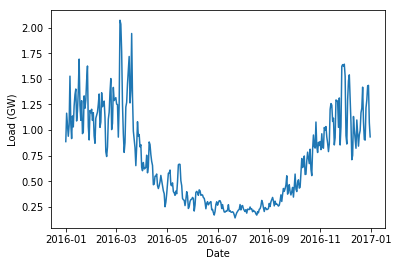

In [11]:
#Plot the commercial & institutional demand profile as load
ax = sns.lineplot(x = P_SC['Date'], y = P_SC['Normalized_Total'] * (E_S_Heat_C)  * 1000, legend = 'full', ci = None)
ylabel = plt.ylabel('Load (GW)')

### Total space heat demand profile

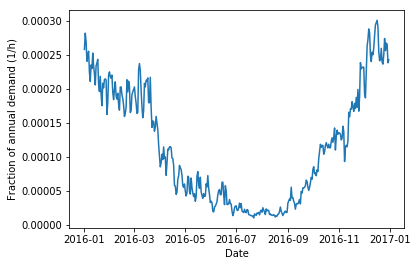

In [12]:
#Create the combined space heat demand profile from the residential
#and the commercial & institutional profile
P_SH = P_SR.loc[:,'Date':'Hour_Ending']

#lets create a datetime column
P_SH['Datetime'] = pd.to_datetime(P_SH['Date'].astype(str) + ' ' + (P_SH['Hour_Ending'] -1).astype(str) + ':00')

#Create separate heat demand profiles for HIGH and LOW scenarios
P_SH['Demand'] = (P_SR['Normalized_Total'] * E_S_Heat_R) + (P_SC['Normalized_Total'] * E_S_Heat_C)
#P_H['HIGH_Demand'] = (P_R['Normalized_Total'] * E_R_HIGH) + (P_C['Normalized_Total'] * E_C_HIGH)

#Create normalized heat demand profiles (These normalized profiles should be equivalent to each other!)
P_SH['Normalized_Demand'] = P_SH['Demand'] / P_SH['Demand'].sum()
#P_H['Normalized_HIGH_Demand'] = P_H['HIGH_Demand'] / P_H['HIGH_Demand'].sum()

#Plot the combined residential and commercial & institutional demand profile as fraction of annual demand
ax = sns.lineplot(x = P_SH['Date'], y = P_SH['Normalized_Demand'], legend = 'full', ci = None)
ylabel = plt.ylabel('Fraction of annual demand (1/h)')

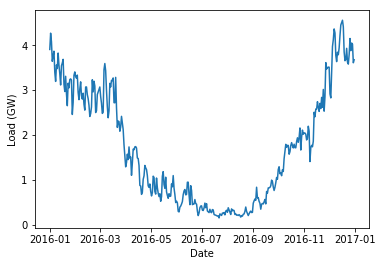

In [13]:
#Plot the combined residential and commercial & institutional demand profile as load
ax = sns.lineplot(x = P_SH['Date'], y = P_SH['Normalized_Demand'] * E_S_Heat * 1000, legend = 'full', ci = None)
ylabel = plt.ylabel('Load (GW)')

## Water heat demand profile

### Residential water heat demand profile

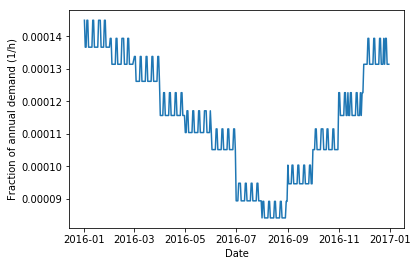

In [14]:
#Residential water heating demand is taken from the IESO CE Tool
P_WR = pd.read_excel(path.join(input_path,'Residential demand profiles/IESO CE Load shapes.xlsx'), sheet_name='Sheet1')

#lets create a date and datetime column
P_WR['Date'] = P_SR['Date']
P_WR['Datetime'] = pd.to_datetime(P_SR['Date'].astype(str) + ' ' + (P_SR['Hour_Ending'] -1).astype(str) + ':00')

#copy the column with our data to the "Normalized_Total" column (we do this to match naming format in other profile dataframes)
#the column in the IESO data is already normalized
P_WR['Normalized_Total'] = P_WR['Residential_Hot_Water']
                
#plot the demand profile
ax = sns.lineplot(x = P_WR['Date'], y = P_WR['Normalized_Total'], legend = 'full', ci = None)
ylabel = plt.ylabel('Fraction of annual demand (1/h)')

### Commercial water heat demand profile

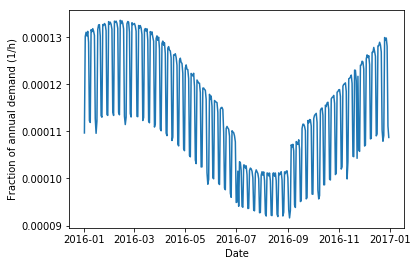

In [15]:
#Commmercial water heat demand profile is derived from 16 types of reference building models published by US DOE.
#Commercial Buildings are weighted to match the building stock in British Columbia
#source data available at: https://openei.org/doe-opendata/dataset/commercial-and-residential-hourly-load-profiles-for-all-tmy3-locations-in-the-united-states

#File names are rather long, let's define the prefix and suffix of file names to save space.
pre = 'RefBldg'
suf = 'New2004_v1.3_7.1_4C_USA_WA_SEATTLE.csv'

#Dictionary of buidling types and their resective relative occurance. DOE Weights for CLimate Zone 4C
bldgDict = {'FullServiceRestaurant' :24.6,
            'Hospital' :5.8,
            'LargeHotel':13.3,
            'LargeOffice' : 4.1,
            'MediumOffice' :48.3,
            'MidriseApartment' : 0,
            'OutPatient' :58.5,
            'PrimarySchool' :16.8,
            'QuickServiceRestaurant' : 75.7,
            'SecondarySchool' :15.2,
            'SmallHotel' :12,
            'SmallOffice' :294.8,
            'Stand-aloneRetail' :227.1,
            'StripMall' :62.8,
            'SuperMarket' :10.8,
            'Warehouse' :110.7}

#the name of the column contains the water heat demand in each csv file
heatColumn = 'Water Heater:WaterSystems:Gas [kW](Hourly)'

#Create a data frame with the dates and HE (hour ending) from our P_R dataframe to store our heat demand.
P_WC = P_SR.loc[:,'Date':'Hour_Ending']
P_WC = P_SC.reset_index(drop=True)

#lets create a datetime column
P_WC['Datetime'] = pd.to_datetime(P_WC['Date'].astype(str) + ' ' + (P_WC['Hour_Ending'] -1).astype(str) + ':00')

#Read the csv files and add the heating demand colomn from each csv file to our dataframe
for bldg, weight in bldgDict.items():
    
    #read each entire csv
    dfTemp = pd.read_csv(path.join(input_path,'Commercial demand profiles/',pre+bldg+suf))
      
    #copy the column with the heat demand into our dataframe
    P_WC.loc[:,bldg] = dfTemp.loc[:, heatColumn] * weight

#Create the sum of all building demands
P_WC.loc[:,'Total'] = P_WC.loc[:, bldgDict.keys()].sum(axis=1)

#Normalize the total Commercial, Institutional and Publich Administration building demands
P_WC['Normalized_Total'] = P_WC['Total'] / P_WC['Total'].sum()

#Plot the commercial & institutional demand profile
ax = sns.lineplot(x = P_WC['Date'], y = P_WC['Normalized_Total'], legend = 'full', ci = None)
ylabel = plt.ylabel('Fraction of annual demand (1/h)')

### Total water heat demand profile

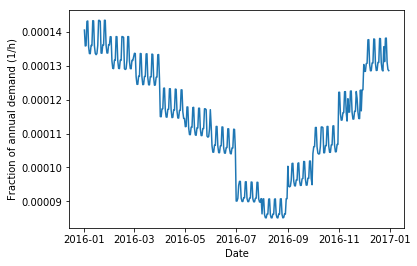

In [16]:
#Create the combined water heat demand profile from the residential
#and the commercial & institutional profile
P_WH = P_SR.loc[:,'Date':'Hour_Ending']

#lets create a datetime column
P_WH['Datetime'] = pd.to_datetime(P_SH['Date'].astype(str) + ' ' + (P_SH['Hour_Ending'] -1).astype(str) + ':00')

#Create water heat demand column [GW]
P_WH['Demand'] = (P_WR['Normalized_Total'] * E_W_Heat_R) + (P_WC['Normalized_Total'] * E_W_Heat_C)

#Create a normalized water heat demand profile [Fraction]
P_WH['Normalized_Demand'] = P_WH['Demand'] / P_WH['Demand'].sum()

#Plot the combined residential and commercial & institutional water heat demand profile
ax = sns.lineplot(x = P_WH['Date'], y = P_WH['Normalized_Demand'], legend = 'full', ci = None)
ylabel = plt.ylabel('Fraction of annual demand (1/h)')

# Output residential and commercial total demand profiles to csv file

In [17]:
#Collect space and water heat demand profiles in a single dataframe
P_H = pd.DataFrame(data=P_SH[['Date','Hour_Ending','Datetime']])

#Add demand columns in Giga Watt
P_H['Residential_Space_Heat_Demand_GW'] = P_SR['Normalized_Total'] * (E_S_Heat_R)  * 1000
P_H['Residential_Water_Heat_Demand_GW'] = P_WR['Normalized_Total'] * (E_W_Heat_R)  * 1000
P_H['Commercial_Space_Heat_Demand_GW'] = P_SC['Normalized_Total'] * (E_S_Heat_C)  * 1000
P_H['Commercial_Water_Heat_Demand_GW'] = P_WC['Normalized_Total'] * (E_W_Heat_C)  * 1000

#write demands to csv file
P_H.to_csv(path.join(output_path,'Metro Vancouver residential and commercial space and water heating hourly end-use demand.csv'), index=False)